In [4]:
import os
import math
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
# Attempt to import openai for GPT interactions. If unavailable, the notebook will simulate a response.
try:
    import openai
    openai.api_key = os.getenv('OPENAI_API_KEY')
except ImportError:
    openai = None


In [10]:

kb_dataset = None
case_dataset = None

try:
    from datasets import load_from_disk  # This requires the `datasets` library to be installed
    kb_ds = load_from_disk('../HF_cache/KBs')
    case_ds = load_from_disk('../HF_cache/cases')
    # Retrieve the GDPR split from each dataset
    if isinstance(kb_ds, dict):
        kb_dataset = kb_ds.get('GDPR', None)
    else:
        kb_dataset = kb_ds['GDPR'] if 'GDPR' in kb_ds else None

    if isinstance(case_ds, dict):
        case_dataset = case_ds.get('GDPR', None)
    else:
        case_dataset = case_ds['GDPR'] if 'GDPR' in case_ds else None
except Exception as e:
    print(f"Could not load actual datasets: {e}")

In [11]:

# Build a dictionary for the knowledge base where keys are lowercase regulation IDs
kb_dict = {item['regulation_id'].lower(): item for item in kb_dataset}

def retrieve_laws(law_ids, kb_dict):
    """
    Given a list of law identifiers, look up the corresponding regulation entries in the knowledge base.
    Returns a list of dictionaries containing 'regulation_id' and 'regulation_content'.
    """
    related = []
    for law_id in law_ids:
        key = law_id.lower()
        if key in kb_dict:
            related.append(kb_dict[key])
    return related


In [12]:

# Choose which case to examine from the dataset. Modify `case_index` to explore different cases.
case_index = 0
case_entry = case_dataset[case_index]

# Collect the list of law article identifiers referenced by the case (followed and violated articles)
law_ids = list(case_entry.get('followed_articles', [])) + list(case_entry.get('violated_articles', []))

# Retrieve the law texts associated with these identifiers
related_laws = retrieve_laws(law_ids, kb_dict)

# Display the case details and associated law identifiers
case_entry, law_ids

({'norm_type': 'prohibit',
  'sender': ['Meta Platforms Ireland Limited'],
  'sender_role': ['Data Controller'],
  'recipient': ['Internal Systems'],
  'recipient_role': ['Data Storage'],
  'subject': ['Users'],
  'subject_role': ['Data Subjects'],
  'information_type': ['Passwords'],
  'consent_form': 'None',
  'purpose': 'Data Storage',
  'followed_articles': [],
  'violated_articles': ['Article 32', 'Article 33', 'Article 34'],
  'case_content': 'Meta Platforms Ireland Limited (MPIL) stored user passwords on their internal systems without encryption. Although external parties did not have access to these passwords, the lack of encryption increased the risk of misuse. Additionally, MPIL did not report or document a data breach related to the storage of these unencrypted passwords.'},
 ['Article 32', 'Article 33', 'Article 34'])

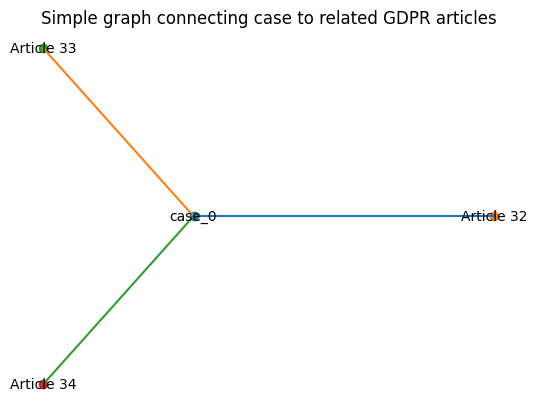

In [13]:

# Build a simple graph representation connecting the case to each related law article
case_node = f"case_{case_index}"
graph = {case_node: law_ids}
for law_id in law_ids:
    graph[law_id] = []  # Initialize an empty adjacency list for each law node

# Visualize the graph using matplotlib
import matplotlib.pyplot as plt
import math

# Assign positions: place the case at the center and laws evenly around a circle
positions = {}
positions[case_node] = (0, 0)
num_laws = len(law_ids)
for idx, law_id in enumerate(law_ids):
    angle = 2 * math.pi * idx / max(1, num_laws)
    positions[law_id] = (math.cos(angle), math.sin(angle))

# Create the plot
fig, ax = plt.subplots()

# Draw edges from the case node to each law node
for law_id in law_ids:
    x_vals = [positions[case_node][0], positions[law_id][0]]
    y_vals = [positions[case_node][1], positions[law_id][1]]
    ax.plot(x_vals, y_vals)  # Using default line color

# Draw nodes
for node, (x, y) in positions.items():
    ax.scatter(x, y)  # Using default point color
    ax.text(x, y, node, ha='center', va='center')

ax.set_title('Simple graph connecting case to related GDPR articles')
ax.axis('off')
plt.show()


In [18]:

# Construct a prompt that includes CI elements and the relevant GDPR provisions
prompt_lines = [
    "You are given the following data flow from the GDPR compliance dataset:",
    f"Sender: {case_entry['sender']} ({case_entry['sender_role']})",
    f"Recipient: {case_entry['recipient']} ({case_entry['recipient_role']})",
    f"Subject: {case_entry['subject']} ({case_entry['subject_role']})",
    f"Information Type: {case_entry['information_type']}",
    f"Consent: {case_entry['consent_form']}",
    f"Purpose: {case_entry['purpose']}",
    "",
    "The following GDPR provisions may apply:"
]

for law in related_laws:
    prompt_lines.append(f"{law['regulation_id']}: {law['regulation_content']}")

prompt_lines.append("")
prompt_lines.append("Is this data transfer permitted, prohibited, or not applicable under the GDPR? Answer with 'permitted', 'prohibited', or 'not applicable' and briefly explain your reasoning.")

prompt = "\n".join(prompt_lines)

# Show the prompt so you can inspect it before sending to the model
print(prompt)


You are given the following data flow from the GDPR compliance dataset:
Sender: ['Meta Platforms Ireland Limited'] (['Data Controller'])
Recipient: ['Internal Systems'] (['Data Storage'])
Subject: ['Users'] (['Data Subjects'])
Information Type: ['Passwords']
Consent: None
Purpose: Data Storage

The following GDPR provisions may apply:
Article 32: "Security of processing"
Article 33: "Notification of a personal data breach to the supervisory authority"
Article 34: "Communication of a personal data breach to the data subject"

Is this data transfer permitted, prohibited, or not applicable under the GDPR? Answer with 'permitted', 'prohibited', or 'not applicable' and briefly explain your reasoning.


In [ ]:

# Query GPT-4o-mini with the constructed prompt.
# If the `openai` library is not available (due to environment restrictions), simulate a response.

if openai is not None:
    try:
        response = openai.ChatCompletion.create(
            model='gpt-4o-mini',
            messages=[
                {'role': 'system', 'content': 'You are a helpful legal assistant.'},
                {'role': 'user', 'content': prompt}
            ],
            max_tokens=256,
            temperature=0.2
        )
        answer = response['choices'][0]['message']['content']
    except Exception as e:
        answer = f"An error occurred calling the OpenAI API: {e}"
else:
    # Simulate a plausible model response if OpenAI is unavailable
    if 'consent' in case_entry['consent_form'].lower() and case_entry['consent_form'].lower() != 'no':
        answer = "permitted — because the data subject has given consent under GDPR Article 6(1)(a), the transfer is allowed."
    else:
        answer = "prohibited — without consent or another lawful basis, transferring personal health data would violate GDPR."

print(answer)


'An error occurred calling the OpenAI API: \n\nYou tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.\n\nYou can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. \n\nAlternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`\n\nA detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742\n'